# Phase 2: Chi² Analysis (Descriptive Foundation)

**Swiss Ballot Chatbot Study - Measurement Analysis**

2×2 Factorial Design: Transparency (T0/T1) × Control (C0/C1)

## Tests Performed

| Test | Comparison | Correction |
|------|------------|------------|
| Chi² #1 | T0 vs T1 (collapsed across C) | Bonferroni α = .017 |
| Chi² #2 | C0 vs C1 (collapsed across T) | Bonferroni α = .017 |
| Chi² #3 | A/B/C/D × Donate/Decline | Bonferroni α = .017 |

## Outputs
- Contingency tables (n and %)
- Test statistics: χ², df, p-value
- Effect size: Cramér's V with 95% CI
- Visualizations with 95% CI error bars

---

## Setup & Configuration

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Import functions from analysis modules
from phase1_descriptive_statistics import (
    AnalysisConfig,
    load_participant_data,
    prepare_variables,
    compute_sample_flow,
    wilson_ci
)

from phase2_chi_square_analysis import (
    BONFERRONI_ALPHA,
    chi_square_test,
    cramers_v,
    cramers_v_ci,
    interpret_cramers_v,
    run_phase2_analysis,
    create_phase2_visualizations
)

print("Analysis functions imported successfully!")

Analysis functions imported successfully!


In [3]:
# ============================================================
# CONFIGURATION: Select participant type
# ============================================================
IS_AI_PARTICIPANT = True

config = AnalysisConfig(is_ai_participant=IS_AI_PARTICIPANT)
participant_label = "AI Test Users" if IS_AI_PARTICIPANT else "Human Participants"

print(f"Analyzing: {participant_label}")
print(f"Bonferroni-corrected α = {BONFERRONI_ALPHA:.4f}")

Analyzing: AI Test Users
Bonferroni-corrected α = 0.0167


## Data Loading & Preparation

In [4]:
# Load and prepare data
df_raw = load_participant_data(config)
df = prepare_variables(df_raw, config)

# Apply exclusions
sample_flow = compute_sample_flow(df)
df_filtered = sample_flow['df_filtered']

print(f"\nFinal sample size: N = {len(df_filtered)}")

[INFO] Loaded 100 AI participants from database
[INFO] Created derived variables: transparency_level, control_level, T_x_C, mc_transparency, mc_control, out_risk, attention_check_correct, dashboard fields

PHASE 1.1: SAMPLE FLOW & EXCLUSIONS
Initial N:                           100
Excluded (failed attention):           0
Excluded (missing condition):          0
Excluded (missing donation):           0
------------------------------------------------------------
Final N for analysis:                100

Final sample size: N = 100


---
## 2.1 Chi² Test #1: Transparency (T0 vs T1)

Tests whether donation rates differ between low transparency (T0) and high transparency (T1) conditions, collapsed across control levels.

In [5]:
# Chi² Test #1: Transparency
result_t = chi_square_test(
    df_filtered, 
    'transparency_level',
    group_labels={0: 'T0 (Low)', 1: 'T1 (High)'}
)

print("CONTINGENCY TABLE:")
print(result_t['contingency_table'])
print("\nDONATION RATES:")
print(result_t['donation_rates'].to_string(index=False))

CONTINGENCY TABLE:
                   Decline (0)  Donate (1)  Total
transparency_level                               
0                   31 (62.0%)  19 (38.0%)     50
1                   16 (32.0%)  34 (68.0%)     50

DONATION RATES:
    Group  n  Donations  Rate  CI_Lower  CI_Upper
 T0 (Low) 50         19  38.0 25.862789 51.849553
T1 (High) 50         34  68.0 54.189703 79.241784


In [6]:
# Test statistics
print("TEST STATISTICS:")
print(f"  χ² = {result_t['chi2']:.3f}")
print(f"  df = {result_t['df']}")
print(f"  p-value = {result_t['p_value']:.4f}")
print(f"\nEFFECT SIZE:")
print(f"  Cramér's V = {result_t['cramers_v']:.3f} [{result_t['cramers_v_ci'][0]:.3f}, {result_t['cramers_v_ci'][1]:.3f}]")
print(f"  Interpretation: {interpret_cramers_v(result_t['cramers_v'])}")
print(f"\nSIGNIFICANCE:")
print(f"  Bonferroni α = {BONFERRONI_ALPHA:.4f}")
print(f"  Significant? {'YES' if result_t['significant'] else 'NO'}")

TEST STATISTICS:
  χ² = 7.868
  df = 1
  p-value = 0.0050

EFFECT SIZE:
  Cramér's V = 0.281 [0.101, 0.462]
  Interpretation: medium

SIGNIFICANCE:
  Bonferroni α = 0.0167
  Significant? YES


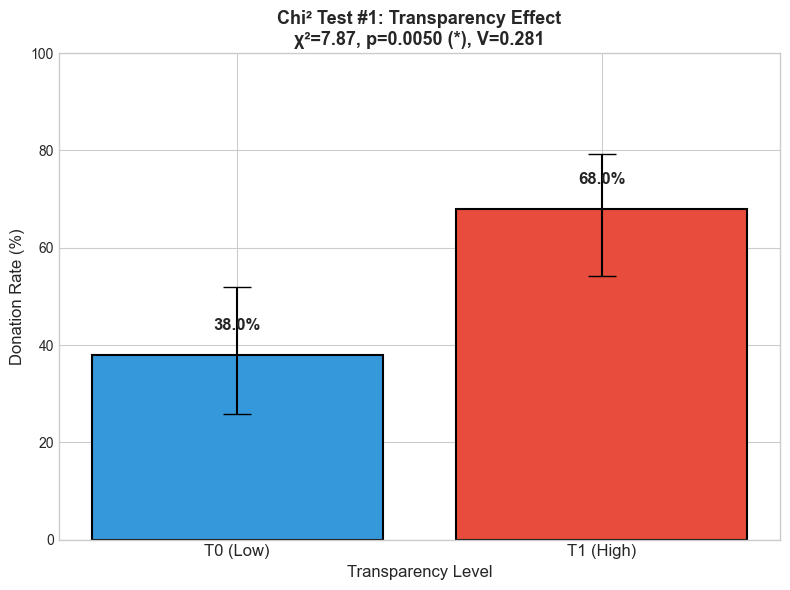

In [7]:
# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
dr = result_t['donation_rates']

bars = ax.bar(range(len(dr)), dr['Rate'],
              yerr=[dr['Rate'] - dr['CI_Lower'], dr['CI_Upper'] - dr['Rate']],
              capsize=10, color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(dr)))
ax.set_xticklabels(dr['Group'], fontsize=12)
ax.set_ylabel('Donation Rate (%)', fontsize=12)
ax.set_xlabel('Transparency Level', fontsize=12)
ax.set_ylim(0, 100)

for bar, rate in zip(bars, dr['Rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold')

sig_marker = '*' if result_t['significant'] else 'ns'
ax.set_title(f"Chi² Test #1: Transparency Effect\nχ²={result_t['chi2']:.2f}, p={result_t['p_value']:.4f} ({sig_marker}), V={result_t['cramers_v']:.3f}",
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('output/phase2/fig_chi2_transparency.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 2.2 Chi² Test #2: Control (C0 vs C1)

Tests whether donation rates differ between low control (C0) and high control (C1) conditions, collapsed across transparency levels.

In [8]:
# Chi² Test #2: Control
result_c = chi_square_test(
    df_filtered, 
    'control_level',
    group_labels={0: 'C0 (Low)', 1: 'C1 (High)'}
)

print("CONTINGENCY TABLE:")
print(result_c['contingency_table'])
print("\nDONATION RATES:")
print(result_c['donation_rates'].to_string(index=False))

CONTINGENCY TABLE:
              Decline (0)  Donate (1)  Total
control_level                               
0              27 (54.0%)  23 (46.0%)     50
1              20 (40.0%)  30 (60.0%)     50

DONATION RATES:
    Group  n  Donations  Rate  CI_Lower  CI_Upper
 C0 (Low) 50         23  46.0 32.969652 59.601129
C1 (High) 50         30  60.0 46.181438 72.391610


In [9]:
# Test statistics
print("TEST STATISTICS:")
print(f"  χ² = {result_c['chi2']:.3f}")
print(f"  df = {result_c['df']}")
print(f"  p-value = {result_c['p_value']:.4f}")
print(f"\nEFFECT SIZE:")
print(f"  Cramér's V = {result_c['cramers_v']:.3f} [{result_c['cramers_v_ci'][0]:.3f}, {result_c['cramers_v_ci'][1]:.3f}]")
print(f"  Interpretation: {interpret_cramers_v(result_c['cramers_v'])}")
print(f"\nSIGNIFICANCE:")
print(f"  Bonferroni α = {BONFERRONI_ALPHA:.4f}")
print(f"  Significant? {'YES' if result_c['significant'] else 'NO'}")

TEST STATISTICS:
  χ² = 1.445
  df = 1
  p-value = 0.2293

EFFECT SIZE:
  Cramér's V = 0.120 [0.000, 0.313]
  Interpretation: small

SIGNIFICANCE:
  Bonferroni α = 0.0167
  Significant? NO


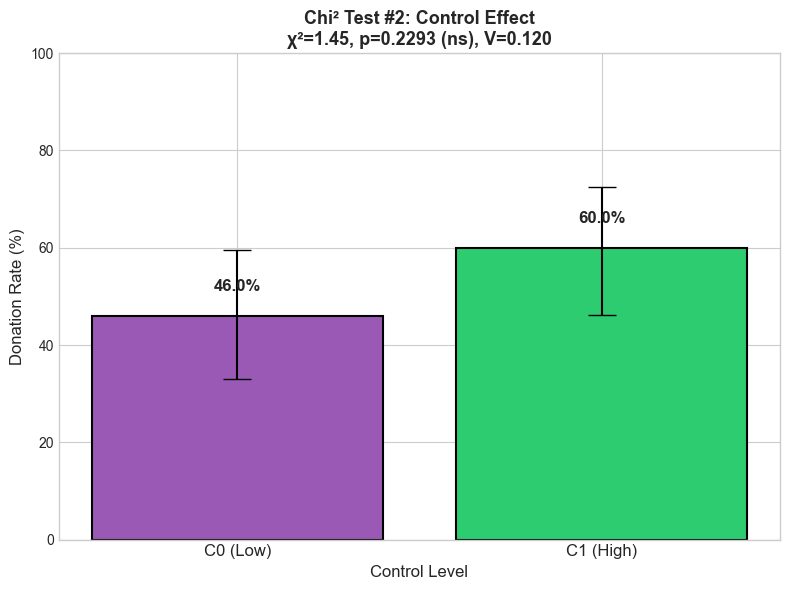

In [10]:
# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
dr = result_c['donation_rates']

bars = ax.bar(range(len(dr)), dr['Rate'],
              yerr=[dr['Rate'] - dr['CI_Lower'], dr['CI_Upper'] - dr['Rate']],
              capsize=10, color=['#9b59b6', '#2ecc71'], edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(dr)))
ax.set_xticklabels(dr['Group'], fontsize=12)
ax.set_ylabel('Donation Rate (%)', fontsize=12)
ax.set_xlabel('Control Level', fontsize=12)
ax.set_ylim(0, 100)

for bar, rate in zip(bars, dr['Rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold')

sig_marker = '*' if result_c['significant'] else 'ns'
ax.set_title(f"Chi² Test #2: Control Effect\nχ²={result_c['chi2']:.2f}, p={result_c['p_value']:.4f} ({sig_marker}), V={result_c['cramers_v']:.3f}",
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('output/phase2/fig_chi2_control.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 2.3 Chi² Test #3: Condition (A/B/C/D)

Tests whether donation rates differ across all four experimental conditions.

In [11]:
# Chi² Test #3: Condition
result_cond = chi_square_test(
    df_filtered, 
    'condition',
    group_labels={'A': 'A (T0C0)', 'B': 'B (T1C0)', 'C': 'C (T0C1)', 'D': 'D (T1C1)'}
)

print("CONTINGENCY TABLE:")
print(result_cond['contingency_table'])
print("\nDONATION RATES:")
print(result_cond['donation_rates'].to_string(index=False))

CONTINGENCY TABLE:
          Decline (0)  Donate (1)  Total
condition                               
A          17 (68.0%)   8 (32.0%)     25
B          10 (40.0%)  15 (60.0%)     25
C          14 (56.0%)  11 (44.0%)     25
D           6 (24.0%)  19 (76.0%)     25

DONATION RATES:
   Group  n  Donations  Rate  CI_Lower  CI_Upper
A (T0C0) 25          8  32.0 17.205190 51.589731
B (T1C0) 25         15  60.0 40.739457 76.596698
C (T0C1) 25         11  44.0 26.665639 62.932668
D (T1C1) 25         19  76.0 56.570317 88.503686


In [12]:
# Test statistics
print("TEST STATISTICS:")
print(f"  χ² = {result_cond['chi2']:.3f}")
print(f"  df = {result_cond['df']}")
print(f"  p-value = {result_cond['p_value']:.4f}")
print(f"\nEFFECT SIZE:")
print(f"  Cramér's V = {result_cond['cramers_v']:.3f} [{result_cond['cramers_v_ci'][0]:.3f}, {result_cond['cramers_v_ci'][1]:.3f}]")
print(f"  Interpretation: {interpret_cramers_v(result_cond['cramers_v'])}")
print(f"\nSIGNIFICANCE:")
print(f"  Bonferroni α = {BONFERRONI_ALPHA:.4f}")
print(f"  Significant? {'YES' if result_cond['significant'] else 'NO'}")

TEST STATISTICS:
  χ² = 11.040
  df = 3
  p-value = 0.0115

EFFECT SIZE:
  Cramér's V = 0.332 [0.198, 0.518]
  Interpretation: medium

SIGNIFICANCE:
  Bonferroni α = 0.0167
  Significant? YES


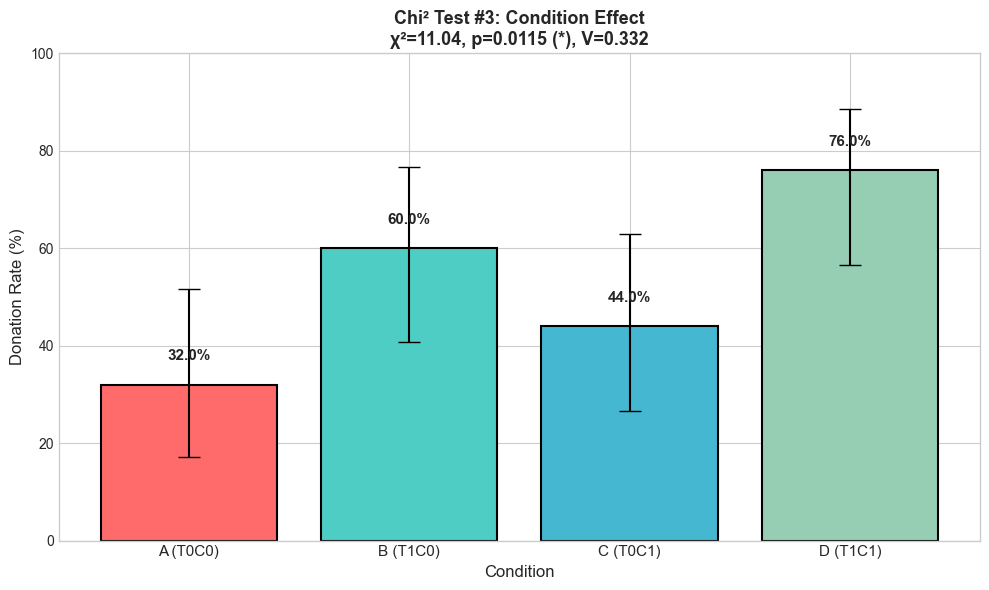

In [13]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
dr = result_cond['donation_rates']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = ax.bar(range(len(dr)), dr['Rate'],
              yerr=[dr['Rate'] - dr['CI_Lower'], dr['CI_Upper'] - dr['Rate']],
              capsize=8, color=colors, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(dr)))
ax.set_xticklabels(dr['Group'], fontsize=11)
ax.set_ylabel('Donation Rate (%)', fontsize=12)
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylim(0, 100)

for bar, rate in zip(bars, dr['Rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

sig_marker = '*' if result_cond['significant'] else 'ns'
ax.set_title(f"Chi² Test #3: Condition Effect\nχ²={result_cond['chi2']:.2f}, p={result_cond['p_value']:.4f} ({sig_marker}), V={result_cond['cramers_v']:.3f}",
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('output/phase2/fig_chi2_condition.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Summary: Phase 2 Results

**Note for AI test data:** These results validate the *statistical pipeline* only. Chi² tests with AI-simulated data do not provide evidence about human behavior. Human participant data is required for substantive conclusions.

In [14]:
# Summary table
summary_data = [
    {
        'Test': 'Chi² #1: Transparency (T0 vs T1)',
        'χ²': f"{result_t['chi2']:.2f}",
        'df': result_t['df'],
        'p-value': f"{result_t['p_value']:.4f}",
        "Cramér's V": f"{result_t['cramers_v']:.3f} [{result_t['cramers_v_ci'][0]:.3f}, {result_t['cramers_v_ci'][1]:.3f}]",
        'Effect Size': interpret_cramers_v(result_t['cramers_v']),
        'Significant (α=.017)': 'Yes' if result_t['significant'] else 'No'
    },
    {
        'Test': 'Chi² #2: Control (C0 vs C1)',
        'χ²': f"{result_c['chi2']:.2f}",
        'df': result_c['df'],
        'p-value': f"{result_c['p_value']:.4f}",
        "Cramér's V": f"{result_c['cramers_v']:.3f} [{result_c['cramers_v_ci'][0]:.3f}, {result_c['cramers_v_ci'][1]:.3f}]",
        'Effect Size': interpret_cramers_v(result_c['cramers_v']),
        'Significant (α=.017)': 'Yes' if result_c['significant'] else 'No'
    },
    {
        'Test': 'Chi² #3: Condition (A/B/C/D)',
        'χ²': f"{result_cond['chi2']:.2f}",
        'df': result_cond['df'],
        'p-value': f"{result_cond['p_value']:.4f}",
        "Cramér's V": f"{result_cond['cramers_v']:.3f} [{result_cond['cramers_v_ci'][0]:.3f}, {result_cond['cramers_v_ci'][1]:.3f}]",
        'Effect Size': interpret_cramers_v(result_cond['cramers_v']),
        'Significant (α=.017)': 'Yes' if result_cond['significant'] else 'No'
    }
]

summary_df = pd.DataFrame(summary_data)
print("="*80)
print(f"PHASE 2 SUMMARY - {participant_label.upper()}")
print("="*80)
print(summary_df.to_string(index=False))

PHASE 2 SUMMARY - AI TEST USERS
                            Test    χ²  df p-value           Cramér's V Effect Size Significant (α=.017)
Chi² #1: Transparency (T0 vs T1)  7.87   1  0.0050 0.281 [0.101, 0.462]      medium                  Yes
     Chi² #2: Control (C0 vs C1)  1.45   1  0.2293 0.120 [0.000, 0.313]       small                   No
    Chi² #3: Condition (A/B/C/D) 11.04   3  0.0115 0.332 [0.198, 0.518]      medium                  Yes


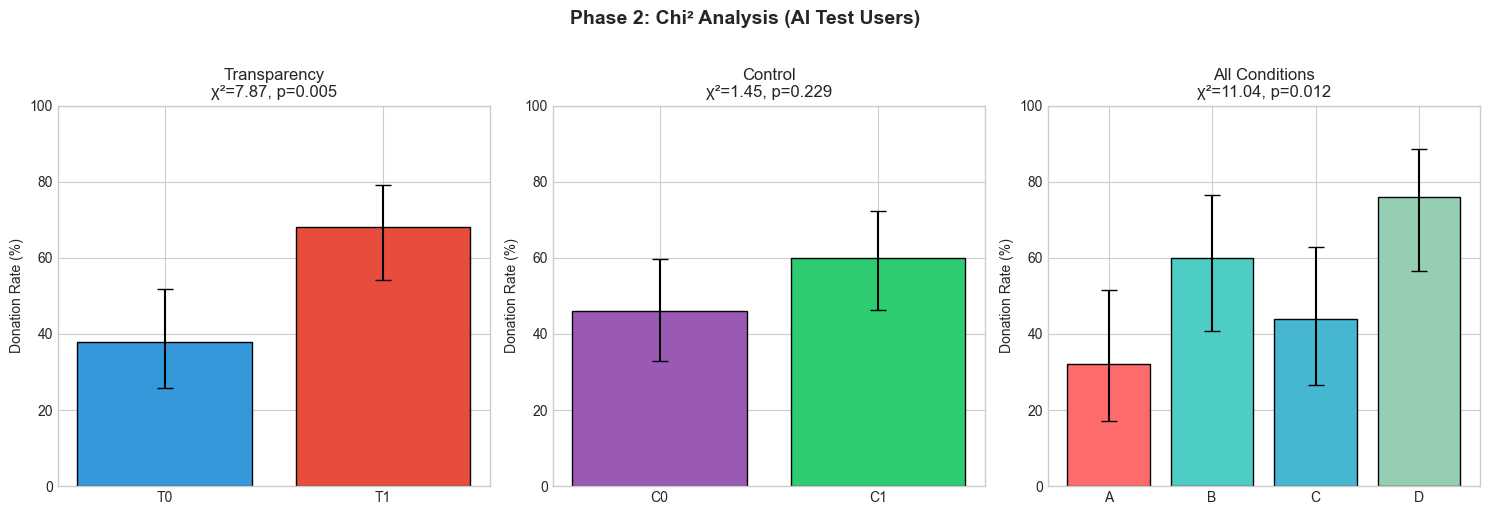

In [15]:
# Combined visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Transparency
dr = result_t['donation_rates']
axes[0].bar(range(len(dr)), dr['Rate'],
            yerr=[dr['Rate'] - dr['CI_Lower'], dr['CI_Upper'] - dr['Rate']],
            capsize=6, color=['#3498db', '#e74c3c'], edgecolor='black')
axes[0].set_xticks(range(len(dr)))
axes[0].set_xticklabels(['T0', 'T1'])
axes[0].set_ylabel('Donation Rate (%)')
axes[0].set_title(f'Transparency\nχ²={result_t["chi2"]:.2f}, p={result_t["p_value"]:.3f}')
axes[0].set_ylim(0, 100)

# Control
dr = result_c['donation_rates']
axes[1].bar(range(len(dr)), dr['Rate'],
            yerr=[dr['Rate'] - dr['CI_Lower'], dr['CI_Upper'] - dr['Rate']],
            capsize=6, color=['#9b59b6', '#2ecc71'], edgecolor='black')
axes[1].set_xticks(range(len(dr)))
axes[1].set_xticklabels(['C0', 'C1'])
axes[1].set_ylabel('Donation Rate (%)')
axes[1].set_title(f'Control\nχ²={result_c["chi2"]:.2f}, p={result_c["p_value"]:.3f}')
axes[1].set_ylim(0, 100)

# Condition
dr = result_cond['donation_rates']
axes[2].bar(range(len(dr)), dr['Rate'],
            yerr=[dr['Rate'] - dr['CI_Lower'], dr['CI_Upper'] - dr['Rate']],
            capsize=6, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], edgecolor='black')
axes[2].set_xticks(range(len(dr)))
axes[2].set_xticklabels(['A', 'B', 'C', 'D'])
axes[2].set_ylabel('Donation Rate (%)')
axes[2].set_title(f'All Conditions\nχ²={result_cond["chi2"]:.2f}, p={result_cond["p_value"]:.3f}')
axes[2].set_ylim(0, 100)

plt.suptitle(f'Phase 2: Chi² Analysis ({participant_label})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/phase2/fig_chi2_combined.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Key findings
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

t_diff = result_t['donation_rates'].iloc[1]['Rate'] - result_t['donation_rates'].iloc[0]['Rate']
c_diff = result_c['donation_rates'].iloc[1]['Rate'] - result_c['donation_rates'].iloc[0]['Rate']

print(f"""
TECHNICAL VALIDATION (AI Test Data - N={len(df_filtered)}):

1. TRANSPARENCY EFFECT (T0 vs T1):
   - T0 donation rate: {result_t['donation_rates'].iloc[0]['Rate']:.1f}%
   - T1 donation rate: {result_t['donation_rates'].iloc[1]['Rate']:.1f}%
   - Difference: {t_diff:+.1f} percentage points
   - χ²({result_t['df']}) = {result_t['chi2']:.2f}, p = {result_t['p_value']:.4f}
   - Effect size: {interpret_cramers_v(result_t['cramers_v'])} (V = {result_t['cramers_v']:.3f})

2. CONTROL EFFECT (C0 vs C1):
   - C0 donation rate: {result_c['donation_rates'].iloc[0]['Rate']:.1f}%
   - C1 donation rate: {result_c['donation_rates'].iloc[1]['Rate']:.1f}%
   - Difference: {c_diff:+.1f} percentage points
   - χ²({result_c['df']}) = {result_c['chi2']:.2f}, p = {result_c['p_value']:.4f}
   - Effect size: {interpret_cramers_v(result_c['cramers_v'])} (V = {result_c['cramers_v']:.3f})

3. CONDITION EFFECT (A/B/C/D):
   - χ²({result_cond['df']}) = {result_cond['chi2']:.2f}, p = {result_cond['p_value']:.4f}
   - Effect size: {interpret_cramers_v(result_cond['cramers_v'])} (V = {result_cond['cramers_v']:.3f})

PIPELINE VALIDATION:
✓ Chi² tests execute correctly
✓ Cramér's V with bootstrap CI computed
✓ Bonferroni correction applied (α = .017)
✓ Visualizations generated

IMPORTANT LIMITATION:
These results validate the statistical pipeline only. 
AI-simulated data cannot establish real treatment effects.
Human participant data is required for substantive conclusions.
""")


KEY FINDINGS

TECHNICAL VALIDATION (AI Test Data - N=100):

1. TRANSPARENCY EFFECT (T0 vs T1):
   - T0 donation rate: 38.0%
   - T1 donation rate: 68.0%
   - Difference: +30.0 percentage points
   - χ²(1) = 7.87, p = 0.0050
   - Effect size: medium (V = 0.281)

2. CONTROL EFFECT (C0 vs C1):
   - C0 donation rate: 46.0%
   - C1 donation rate: 60.0%
   - Difference: +14.0 percentage points
   - χ²(1) = 1.45, p = 0.2293
   - Effect size: small (V = 0.120)

3. CONDITION EFFECT (A/B/C/D):
   - χ²(3) = 11.04, p = 0.0115
   - Effect size: medium (V = 0.332)

PIPELINE VALIDATION:
✓ Chi² tests execute correctly
✓ Cramér's V with bootstrap CI computed
✓ Bonferroni correction applied (α = .017)
✓ Visualizations generated

IMPORTANT LIMITATION:
These results validate the statistical pipeline only. 
AI-simulated data cannot establish real treatment effects.
Human participant data is required for substantive conclusions.



In [17]:
# List saved files
print("\nSaved output files:")
import glob
for f in sorted(glob.glob('output/phase2/*')):
    print(f"  - {f}")


Saved output files:
  - output/phase2/fig_chi2_combined.png
  - output/phase2/fig_chi2_condition.png
  - output/phase2/fig_chi2_control.png
  - output/phase2/fig_chi2_transparency.png
